In [1]:
import numpy as np
import math
import time
import cvxpy as cp
import os
import copy
import cv2
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
from matplotlib.animation import FFMpegWriter
from queue import PriorityQueue
from scipy.stats import norm

Remember to change the root_path to match your directories

In [2]:
from google.colab import drive
drive.mount('/content/drive')
root_path = 'drive/MyDrive/Colab Notebooks/Compatible Constraint Selection'
os.chdir(root_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Compatible Constraint Selection Demo

In this demo, we demonstrate a few test scenarios included in our paper to show the efficiency and performance of the proposed Lagrange score based algorithms in an environment with known disturbances where a robot is assigned to:

1) Soft Constraints:

Arrive at each blue-colored waypoints in specified order

and

2) Hard Constraints:

Arrive at the final waypoint (red-colored) at specified time and obey all physical constraints attached to the robot model including maximum speed, maximum acceleration (for double integrator dynamics) and the robot dynamical model without running into static obstacles (black-colored) in the environment.

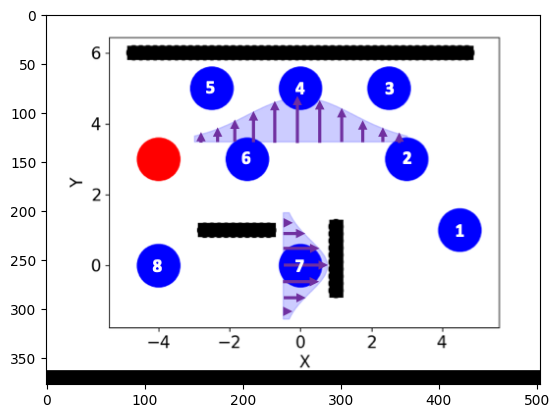

In [3]:
# Sample Environment
img = cv2.imread("Images/env_2.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [4]:
from src.utils.Safe_Set_Series import *
from src.utils.scenario_disturb import *

In [5]:
from src.predictive_frame_lag import *
from src.predictive_frame_slack import *

# Scenario 2

In this scenario, the robot is assigned to arrive at 8 waypoints before arriving at the final waypoint as shown:

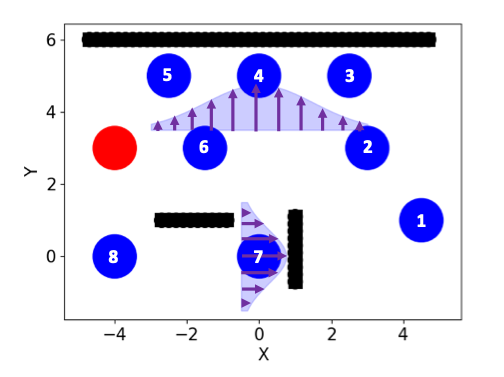

We used a single intergator dynamics as the robot model in this testing scenario. With an increase in the level of disturbance (Low to High), the robot is expected to arrive at less waypoints (which is designed as soft constraints that can be dropped if needed) in order to meet all hard constraints.

In [6]:
# Sim Parameters
dt = 0.1
tf = 60
num_steps = int(tf/dt)
final_wpt_time = 60

In [7]:
# Define Parameters for CBF
U_max = 1.0 #Velocity Maximum
d_max = 0.6 #Radius of each waypoint
alpha_values = [0.4, 0.0]
beta_values = [1.8, 0.0]
num_constraints_soft1 = 1 #Becasue we take the waypoint into the CLF-CBF QP optimization problem one at a time
robot_type = 'SingleIntegrator2D'
scenario_num = 2

In [8]:
# Define Series of Safe Sets
centroids = scenario_waypoints(scenario_num,robot_type)

#Define static obstacles
obstacle_list_x_1 = np.arange(start=-4.8+0.1,stop=4.8+0.1, step=0.2)
obstacle_list_y_1 = np.zeros(shape=obstacle_list_x_1.shape)+6.0
obstacle_list_1 = np.vstack((obstacle_list_x_1,obstacle_list_y_1)).T

obstacle_list_x_2 = np.arange(start=-2.8+0.1,stop=-0.8+0.1, step=0.2)
obstacle_list_y_2 = np.zeros(shape=obstacle_list_x_2.shape)+1.0
obstacle_list_2 = np.vstack((obstacle_list_x_2,obstacle_list_y_2)).T

obstacle_list_y_3 = np.arange(start=-0.8+0.1, stop=1.2+0.1, step=0.2)
obstacle_list_x_3 = np.zeros(shape=obstacle_list_y_3.shape)+1.0
obstacle_list_3 = np.vstack((obstacle_list_x_3,obstacle_list_y_3)).T
obstacle_list = np.vstack((obstacle_list_1,obstacle_list_2))
obstacle_list = np.vstack((obstacle_list,obstacle_list_3))

num_constraints_hard1 = obstacle_list.shape[0] + 1
radii = np.zeros((centroids.shape[0],))+d_max
Safe_Set_Series = Safe_Set_Series2D(centroids=centroids,radii=radii)

In [9]:
#Define Disturbance
disturbance = True
disturb_max = 1.25*U_max
# 1.0 for Low
# 1.2 for Medium
# 1.5 for High
disturb_std = 1.5
f_max_1 = 1/(disturb_std*math.sqrt(2*math.pi))
f_max_2 = f_max_1/0.5

# Feasible Subproblem Algorithm (Algorithm 1) on r_lag

In [10]:
reward_list = np.array([1,1,1,1,1,1,1,1,0])
reward_max = np.sum(reward_list)
x0 = np.array([5.0,0.0])

t_step = int(final_wpt_time/len(reward_list))
t_list = np.arange(t_step, final_wpt_time+t_step, t_step)

teration, best_comb, best_traj, reward = deterministic_lag(scenario_num=scenario_num, robot_type=robot_type, x0=x0, x_r_list=centroids, time_horizon=tf, reward_max=reward_max, radius_list=radii, \
                                                    alpha_values=alpha_values, beta_values=beta_values, reward_list=reward_list, U_max=U_max, V_max=0, obstacle_list=obstacle_list, dt=dt, \
                                                    disturbance=disturbance, disturb_std=disturb_std, disturb_max=disturb_max, num_constraints_hard=num_constraints_hard1)

print('Reward: ', reward )

/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Reward:  5


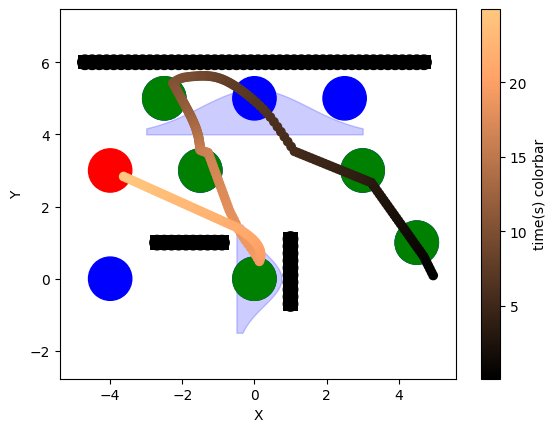

In [11]:
# Plot
x_min = -6
x_max = 6
y_min = -2
y_max = 6
fig = plt.figure()
ax = plt.axes(xlim=(x_min,x_max),ylim=(y_min,y_max+2))
ax.set_xlabel("X")
ax.set_ylabel("Y")

rect = patches.Rectangle((-4.9, y_max-0.2), 9.8, 0.4, linewidth=1, edgecolor='none', facecolor='k')

# Add the patch to the Axes
ax.add_patch(rect)
rect = patches.Rectangle((-2.9, 0.8), 2.2, 0.4, linewidth=1, edgecolor='none', facecolor='k')

# Add the patch to the Axes
ax.add_patch(rect)

rect = patches.Rectangle((0.8, -0.9), 0.4, 2.2, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)

for i in range(0,obstacle_list.shape[0]):
    circle = patches.Circle(obstacle_list[i,:], radius=0.2, color='black', zorder=0)
    ax.add_patch(circle)

for i in range(0,centroids.shape[0]):
    if i != centroids.shape[0]-1:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='blue', zorder=0)
    else:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='red', zorder=0)
    ax.add_patch(circle)

x_disturb_1 = np.arange(start=-2*disturb_std, stop=2*disturb_std+0.1, step=0.1)
y_disturb_1 = norm.pdf(x_disturb_1, loc=0, scale=disturb_std)/f_max_1 * disturb_max + 4.0
ax.fill_between(x_disturb_1, y_disturb_1, 4.0, alpha=0.2, color='blue')
y_disturb_2 = np.arange(start=-2*(disturb_std*0.5), stop=2*(disturb_std*0.5)+0.1, step=0.1)
x_disturb_2 = norm.pdf(y_disturb_2, loc=0, scale=disturb_std*0.5)/f_max_2 * disturb_max - 0.5
ax.fill_betweenx(y_disturb_2,x_disturb_2,-0.5, alpha=0.2, color='blue')

x_list = best_traj["x"]
y_list = best_traj["y"]
t_list = best_traj["t"]

for i in range(len(best_comb)-1):
    if best_comb[i] == 1:
        centroid = centroids[i,:]
        r = radii[i]
        circle = patches.Circle(centroid, radius=r, color='green', zorder=2)
        ax.add_patch(circle)
im = ax.scatter(x_list,y_list,cmap='copper',c=t_list, zorder=100)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('time(s) colorbar')

ax.axis('equal')
plt.rcParams.update({'font.size': 15})
plt.show()

# Feasible Subproblem Algorithm (Algorithm 1) on r_chinneck

In [12]:
reward_list = np.array([1,1,1,1,1,1,1,1,0])
reward_max = np.sum(reward_list)
x0 = np.array([5.0,0.0])

t_step = int(final_wpt_time/len(reward_list))
t_list = np.arange(t_step, final_wpt_time+t_step, t_step)

teration, best_comb, best_traj, reward = deterministic_chinneck_1(scenario_num=scenario_num, robot_type=robot_type, x0=x0, x_r_list=centroids, time_horizon=tf, reward_max=reward_max, radius_list=radii, \
                                                    alpha_values=alpha_values, beta_values=beta_values, reward_list=reward_list, U_max=U_max, V_max=0, obstacle_list=obstacle_list, dt=dt, \
                                                    disturbance=disturbance, disturb_std=disturb_std, disturb_max=disturb_max, num_constraints_hard=num_constraints_hard1)

print('Reward: ', reward )

Reward:  0


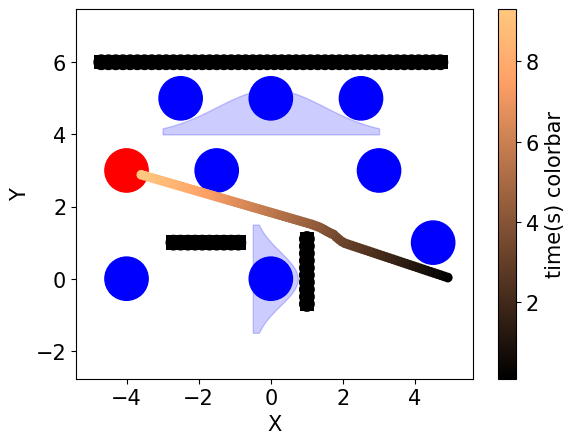

In [14]:
# Plot
x_min = -6
x_max = 6
y_min = -2
y_max = 6
fig = plt.figure()
ax = plt.axes(xlim=(x_min,x_max),ylim=(y_min,y_max+2))
ax.set_xlabel("X")
ax.set_ylabel("Y")

rect = patches.Rectangle((-4.9, y_max-0.2), 9.8, 0.4, linewidth=1, edgecolor='none', facecolor='k')

# Add the patch to the Axes
ax.add_patch(rect)
rect = patches.Rectangle((-2.9, 0.8), 2.2, 0.4, linewidth=1, edgecolor='none', facecolor='k')

# Add the patch to the Axes
ax.add_patch(rect)

rect = patches.Rectangle((0.8, -0.9), 0.4, 2.2, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)

for i in range(0,obstacle_list.shape[0]):
    circle = patches.Circle(obstacle_list[i,:], radius=0.2, color='black', zorder=0)
    ax.add_patch(circle)

for i in range(0,centroids.shape[0]):
    if i != centroids.shape[0]-1:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='blue', zorder=0)
    else:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='red', zorder=0)
    ax.add_patch(circle)

x_disturb_1 = np.arange(start=-2*disturb_std, stop=2*disturb_std+0.1, step=0.1)
y_disturb_1 = norm.pdf(x_disturb_1, loc=0, scale=disturb_std)/f_max_1 * disturb_max + 4.0
ax.fill_between(x_disturb_1, y_disturb_1, 4.0, alpha=0.2, color='blue')
y_disturb_2 = np.arange(start=-2*(disturb_std*0.5), stop=2*(disturb_std*0.5)+0.1, step=0.1)
x_disturb_2 = norm.pdf(y_disturb_2, loc=0, scale=disturb_std*0.5)/f_max_2 * disturb_max - 0.5
ax.fill_betweenx(y_disturb_2,x_disturb_2,-0.5, alpha=0.2, color='blue')

x_list = best_traj["x"]
y_list = best_traj["y"]
t_list = best_traj["t"]

for i in range(len(best_comb)-1):
    if best_comb[i] == 1:
        centroid = centroids[i,:]
        r = radii[i]
        circle = patches.Circle(centroid, radius=r, color='green', zorder=2)
        ax.add_patch(circle)
im = ax.scatter(x_list,y_list,cmap='copper',c=t_list, zorder=100)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('time(s) colorbar')

ax.axis('equal')
plt.rcParams.update({'font.size': 15})
plt.show()

# Greedy Algorithm (Algorithm 2)using r_lag

In [15]:
reward_list = np.array([1,1,1,1,1,1,1,1,0])
reward_max = np.sum(reward_list)
x0 = np.array([5.0,0.0])

t_step = int(final_wpt_time/len(reward_list))
t_list = np.arange(t_step, final_wpt_time+t_step, t_step)

teration, best_comb, best_traj, reward = greedy_lag(scenario_num=scenario_num, robot_type=robot_type, x0=x0, x_r_list=centroids, time_horizon=tf, reward_max=reward_max, radius_list=radii, \
                                                    alpha_values=alpha_values, beta_values=beta_values, reward_list=reward_list, U_max=U_max, V_max=0, obstacle_list=obstacle_list, dt=dt, \
                                                    disturbance=disturbance, disturb_std=disturb_std, disturb_max=disturb_max, num_constraints_hard=num_constraints_hard1)

print('Reward: ', reward )

Reward:  1


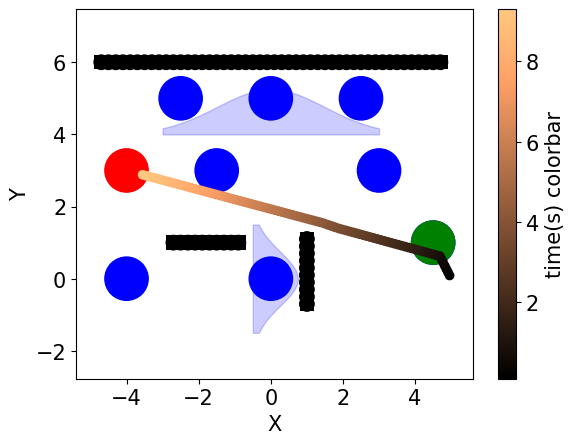

In [16]:
# Plot
x_min = -6
x_max = 6
y_min = -2
y_max = 6
fig = plt.figure()
ax = plt.axes(xlim=(x_min,x_max),ylim=(y_min,y_max+2))
ax.set_xlabel("X")
ax.set_ylabel("Y")

rect = patches.Rectangle((-4.9, y_max-0.2), 9.8, 0.4, linewidth=1, edgecolor='none', facecolor='k')

# Add the patch to the Axes
ax.add_patch(rect)
rect = patches.Rectangle((-2.9, 0.8), 2.2, 0.4, linewidth=1, edgecolor='none', facecolor='k')

# Add the patch to the Axes
ax.add_patch(rect)

rect = patches.Rectangle((0.8, -0.9), 0.4, 2.2, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)

for i in range(0,obstacle_list.shape[0]):
    circle = patches.Circle(obstacle_list[i,:], radius=0.2, color='black', zorder=0)
    ax.add_patch(circle)

for i in range(0,centroids.shape[0]):
    if i != centroids.shape[0]-1:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='blue', zorder=0)
    else:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='red', zorder=0)
    ax.add_patch(circle)

x_disturb_1 = np.arange(start=-2*disturb_std, stop=2*disturb_std+0.1, step=0.1)
y_disturb_1 = norm.pdf(x_disturb_1, loc=0, scale=disturb_std)/f_max_1 * disturb_max + 4.0
ax.fill_between(x_disturb_1, y_disturb_1, 4.0, alpha=0.2, color='blue')
y_disturb_2 = np.arange(start=-2*(disturb_std*0.5), stop=2*(disturb_std*0.5)+0.1, step=0.1)
x_disturb_2 = norm.pdf(y_disturb_2, loc=0, scale=disturb_std*0.5)/f_max_2 * disturb_max - 0.5
ax.fill_betweenx(y_disturb_2,x_disturb_2,-0.5, alpha=0.2, color='blue')

x_list = best_traj["x"]
y_list = best_traj["y"]
t_list = best_traj["t"]

for i in range(len(best_comb)-1):
    if best_comb[i] == 1:
        centroid = centroids[i,:]
        r = radii[i]
        circle = patches.Circle(centroid, radius=r, color='green', zorder=2)
        ax.add_patch(circle)
im = ax.scatter(x_list,y_list,cmap='copper',c=t_list, zorder=100)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('time(s) colorbar')

ax.axis('equal')
plt.rcParams.update({'font.size': 15})
plt.show()

# Optimal Solution from Reachability

Notice the optimal solution takes a long time (about 7hrs) to run, so we will only provide the final output of the optimal solution here, but readers can run

```
python3 reachability_optimal_scenario_X.py
```

in each ```scenario_X``` folder under ```tests``` to generate the output.

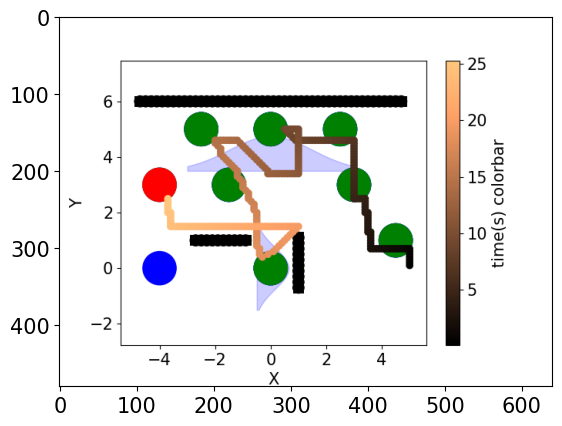

In [18]:
# Optimal Solution from reachability
img = cv2.imread("Images/opt_8_med.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Optimal Solution from Exhaustive Search

Notice the optimal solution from exhaustive search takes a long time (about 3-5 mins) to run, so we will only provide the final output of the optimal solution here, but readers can run

```
python3 Exhaustive_cbf_scenario_X.py
```

in each ```scenario_X``` folder under ```tests``` to generate the output.

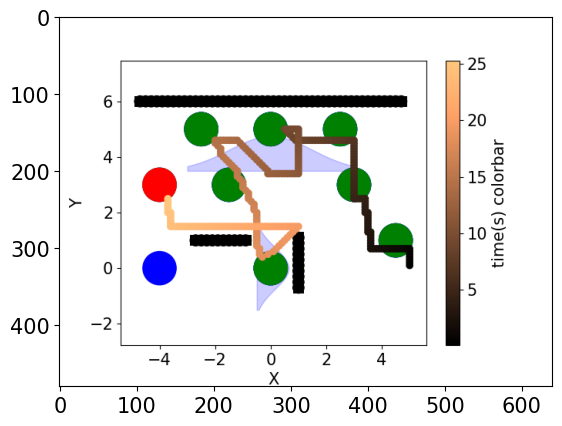

In [19]:
# Optimal Solution from exhaustive search
img = cv2.imread("Images/opt_8_med.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

#Double Integrator Scenario 3

In this testing scenario, we have a double integrator dynamics (Unicycle) as the robot model, and each waypoint is rewarded differently as shown:



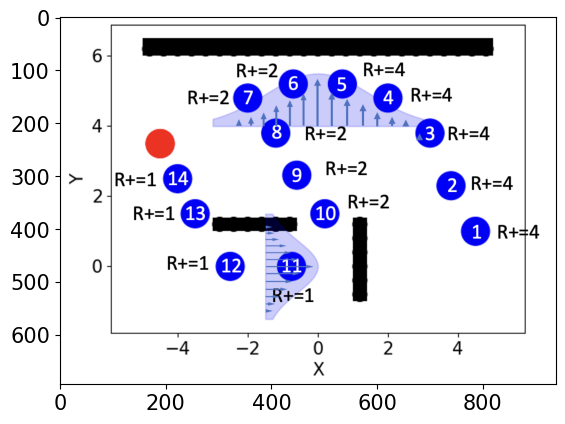

In [ ]:
# Sample Environment
img = cv2.imread("Images/sample_env3.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [20]:
# Sim Parameters
dt = 0.1
t = 0
tf = 60
num_steps = int(tf/dt)

In [21]:
# Define Parameters for CBF
U_max = 1.0
d_max = 0.4
V_max = 1.0

alpha_values = [0.2, 0.2]
beta_values = [5.0, 5.0]
robot_type = 'DoubleIntegrator2D'
scenario_num = 3
num_constraints_soft1 = 1

In [22]:
# Define Series of Safe Sets
centroids = scenario_waypoints(scenario_num,robot_type)

obstacle_list_x_1 = np.arange(start=-4.8+0.1,stop=4.8+0.1, step=0.2)
obstacle_list_y_1 = np.zeros(shape=obstacle_list_x_1.shape)+6.0
obstacle_list_1 = np.vstack((obstacle_list_x_1,obstacle_list_y_1)).T

obstacle_list_x_2 = np.arange(start=-2.8+0.1,stop=-0.8+0.1, step=0.2)
obstacle_list_y_2 = np.zeros(shape=obstacle_list_x_2.shape)+1.0
obstacle_list_2 = np.vstack((obstacle_list_x_2,obstacle_list_y_2)).T

obstacle_list_y_3 = np.arange(start=-0.8+0.1, stop=1.2+0.1, step=0.2)
obstacle_list_x_3 = np.zeros(shape=obstacle_list_y_3.shape)+1.0
obstacle_list_3 = np.vstack((obstacle_list_x_3,obstacle_list_y_3)).T
obstacle_list = np.vstack((obstacle_list_1,obstacle_list_2))
obstacle_list = np.vstack((obstacle_list,obstacle_list_3))

num_constraints_hard1 = obstacle_list.shape[0] + 1
radii = np.zeros((centroids.shape[0],))+d_max
Safe_Set_Series = Safe_Set_Series2D(centroids=centroids,radii=radii)

In [23]:
#Define Disturbance
disturbance = True
disturb_max = 1.5*U_max
disturb_std = 1.5
f_max_1 = 1/(disturb_std*math.sqrt(2*math.pi))
f_max_2 = f_max_1*2.0

# Feasible Subproblem Algorithm (Algorithm 1) on r_lag

In [24]:
reward_list = np.array([1,2,3,4,1,2,3,4,1,2,3,2,1,2,0])
reward_max = np.sum(reward_list)
x0 = np.array([4.8,0.0,0.0,0.0])


iteration, best_comb, best_traj, reward = deterministic_lag(robot_type=robot_type, scenario_num=scenario_num, x0=x0, x_r_list=centroids, time_horizon=tf, reward_max=reward_max,radius_list=radii, \
                                                            alpha_values=alpha_values, beta_values=beta_values, reward_list=reward_list, U_max = U_max, V_max = V_max, dt=dt, disturbance=disturbance, \
                                                            disturb_std=disturb_std, disturb_max=disturb_max, obstacle_list=obstacle_list, \
                                                            num_constraints_hard=num_constraints_hard1)

print('Reward: ', reward )


/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


Reward:  25


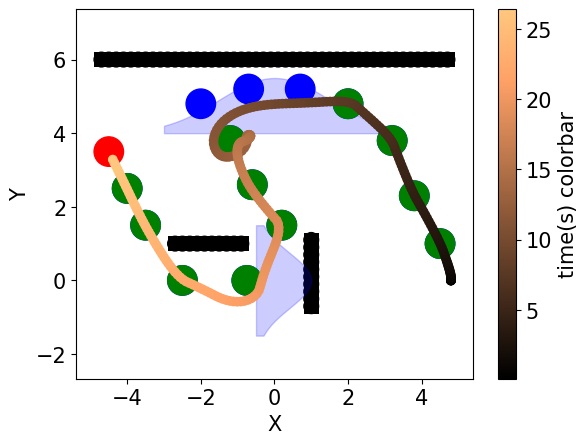

In [25]:
# Plot
plt.ion()
x_min = -6
x_max = 6
y_min = -2
y_max = 6
fig = plt.figure()
ax = plt.axes(xlim=(x_min,x_max),ylim=(y_min,y_max+2))
ax.set_xlabel("X")
ax.set_ylabel("Y")

rect = patches.Rectangle((-4.9, y_max-0.2), 9.8, 0.4, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)
rect = patches.Rectangle((-2.9, 0.8), 2.2, 0.4, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)
rect = patches.Rectangle((0.8, -0.9), 0.4, 2.2, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)
for i in range(0,obstacle_list.shape[0]):
    circle = patches.Circle(obstacle_list[i,:], radius=0.2, color='black', zorder=0)
    ax.add_patch(circle)
ax.axis('equal')

for i in range(0,centroids.shape[0]):
    if i != centroids.shape[0]-1:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='blue', zorder=0)
    else:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='red', zorder=0)
    ax.add_patch(circle)

x_disturb_1 = np.arange(start=-2*disturb_std, stop=2*disturb_std+0.1, step=0.1)
y_disturb_1 = norm.pdf(x_disturb_1, loc=0, scale=disturb_std)/f_max_1 * disturb_max + 4.0
ax.fill_between(x_disturb_1, y_disturb_1, 4.0, alpha=0.2, color='blue')

y_disturb_2 = np.arange(start=-2*(disturb_std*0.5), stop=2*(disturb_std*0.5)+0.1, step=0.1)
x_disturb_2 = norm.pdf(y_disturb_2, loc=0, scale=disturb_std*0.5)/f_max_2 * disturb_max - 0.5
ax.fill_betweenx(y_disturb_2,x_disturb_2,-0.5, alpha=0.2, color='blue')

x_list = best_traj["x"]
y_list = best_traj["y"]
t_list = best_traj["t"]

for i in range(len(best_comb)-1):
    if best_comb[i] == 1:
        centroid = centroids[i,:]
        r = radii[i]
        circle = patches.Circle(centroid, radius=r, color='green', zorder=2)
        ax.add_patch(circle)
im = ax.scatter(x_list,y_list,cmap='copper',c=t_list, zorder=100)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('time(s) colorbar')

ax.axis('equal')
plt.rcParams.update({'font.size': 15})
plt.show()

# Feasible Subproblem Algorithm (Algorithm 1) on r_chinneck

In [26]:
reward_list = np.array([1,2,3,4,1,2,3,4,1,2,3,2,1,2,0])
reward_max = np.sum(reward_list)
x0 = np.array([4.8,0.0,0.0,0.0])


iteration, best_comb, best_traj, reward = deterministic_chinneck_1(robot_type=robot_type, scenario_num=scenario_num, x0=x0, x_r_list=centroids, time_horizon=tf, reward_max=reward_max,radius_list=radii, \
                                                            alpha_values=alpha_values, beta_values=beta_values, reward_list=reward_list, U_max = U_max, V_max = V_max, dt=dt, disturbance=disturbance, \
                                                            disturb_std=disturb_std, disturb_max=disturb_max, obstacle_list=obstacle_list, \
                                                            num_constraints_hard=num_constraints_hard1)

print('Reward: ', reward )

Reward:  6


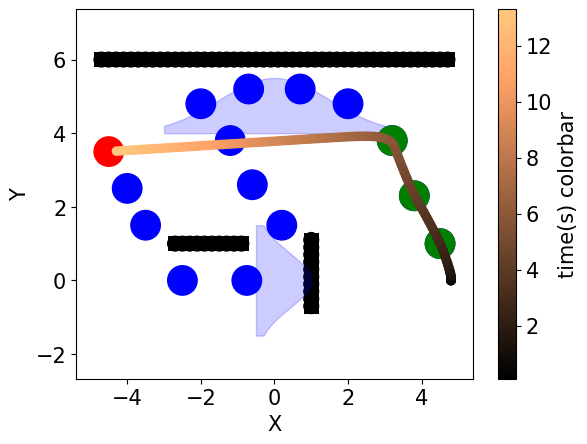

In [27]:
# Plot
plt.ion()
x_min = -6
x_max = 6
y_min = -2
y_max = 6
fig = plt.figure()
ax = plt.axes(xlim=(x_min,x_max),ylim=(y_min,y_max+2))
ax.set_xlabel("X")
ax.set_ylabel("Y")

rect = patches.Rectangle((-4.9, y_max-0.2), 9.8, 0.4, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)
rect = patches.Rectangle((-2.9, 0.8), 2.2, 0.4, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)
rect = patches.Rectangle((0.8, -0.9), 0.4, 2.2, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)
for i in range(0,obstacle_list.shape[0]):
    circle = patches.Circle(obstacle_list[i,:], radius=0.2, color='black', zorder=0)
    ax.add_patch(circle)
ax.axis('equal')

for i in range(0,centroids.shape[0]):
    if i != centroids.shape[0]-1:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='blue', zorder=0)
    else:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='red', zorder=0)
    ax.add_patch(circle)

x_disturb_1 = np.arange(start=-2*disturb_std, stop=2*disturb_std+0.1, step=0.1)
y_disturb_1 = norm.pdf(x_disturb_1, loc=0, scale=disturb_std)/f_max_1 * disturb_max + 4.0
ax.fill_between(x_disturb_1, y_disturb_1, 4.0, alpha=0.2, color='blue')

y_disturb_2 = np.arange(start=-2*(disturb_std*0.5), stop=2*(disturb_std*0.5)+0.1, step=0.1)
x_disturb_2 = norm.pdf(y_disturb_2, loc=0, scale=disturb_std*0.5)/f_max_2 * disturb_max - 0.5
ax.fill_betweenx(y_disturb_2,x_disturb_2,-0.5, alpha=0.2, color='blue')

x_list = best_traj["x"]
y_list = best_traj["y"]
t_list = best_traj["t"]

for i in range(len(best_comb)-1):
    if best_comb[i] == 1:
        centroid = centroids[i,:]
        r = radii[i]
        circle = patches.Circle(centroid, radius=r, color='green', zorder=2)
        ax.add_patch(circle)
im = ax.scatter(x_list,y_list,cmap='copper',c=t_list, zorder=100)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('time(s) colorbar')

ax.axis('equal')
plt.rcParams.update({'font.size': 15})
plt.show()

# Greedy Algorithm (Algorithm 2) on r_lag

In [28]:
reward_list = np.array([1,2,3,4,1,2,3,4,1,2,3,2,1,2,0])
reward_max = np.sum(reward_list)
x0 = np.array([4.8,0.0,0.0,0.0])


iteration, best_comb, best_traj, reward = greedy_lag(robot_type=robot_type, scenario_num=scenario_num, x0=x0, x_r_list=centroids, time_horizon=tf, reward_max=reward_max,radius_list=radii, \
                                                            alpha_values=alpha_values, beta_values=beta_values, reward_list=reward_list, U_max = U_max, V_max = V_max, dt=dt, disturbance=disturbance, \
                                                            disturb_std=disturb_std, disturb_max=disturb_max, obstacle_list=obstacle_list, \
                                                            num_constraints_hard=num_constraints_hard1)

print('Reward: ', reward )

Reward:  22


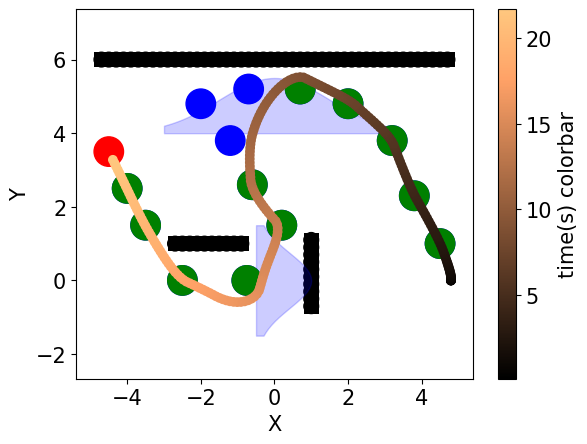

In [29]:
# Plot
plt.ion()
x_min = -6
x_max = 6
y_min = -2
y_max = 6
fig = plt.figure()
ax = plt.axes(xlim=(x_min,x_max),ylim=(y_min,y_max+2))
ax.set_xlabel("X")
ax.set_ylabel("Y")

rect = patches.Rectangle((-4.9, y_max-0.2), 9.8, 0.4, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)
rect = patches.Rectangle((-2.9, 0.8), 2.2, 0.4, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)
rect = patches.Rectangle((0.8, -0.9), 0.4, 2.2, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)
for i in range(0,obstacle_list.shape[0]):
    circle = patches.Circle(obstacle_list[i,:], radius=0.2, color='black', zorder=0)
    ax.add_patch(circle)
ax.axis('equal')

for i in range(0,centroids.shape[0]):
    if i != centroids.shape[0]-1:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='blue', zorder=0)
    else:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='red', zorder=0)
    ax.add_patch(circle)

x_disturb_1 = np.arange(start=-2*disturb_std, stop=2*disturb_std+0.1, step=0.1)
y_disturb_1 = norm.pdf(x_disturb_1, loc=0, scale=disturb_std)/f_max_1 * disturb_max + 4.0
ax.fill_between(x_disturb_1, y_disturb_1, 4.0, alpha=0.2, color='blue')

y_disturb_2 = np.arange(start=-2*(disturb_std*0.5), stop=2*(disturb_std*0.5)+0.1, step=0.1)
x_disturb_2 = norm.pdf(y_disturb_2, loc=0, scale=disturb_std*0.5)/f_max_2 * disturb_max - 0.5
ax.fill_betweenx(y_disturb_2,x_disturb_2,-0.5, alpha=0.2, color='blue')

x_list = best_traj["x"]
y_list = best_traj["y"]
t_list = best_traj["t"]

for i in range(len(best_comb)-1):
    if best_comb[i] == 1:
        centroid = centroids[i,:]
        r = radii[i]
        circle = patches.Circle(centroid, radius=r, color='green', zorder=2)
        ax.add_patch(circle)
im = ax.scatter(x_list,y_list,cmap='copper',c=t_list, zorder=100)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('time(s) colorbar')

ax.axis('equal')
plt.rcParams.update({'font.size': 15})
plt.show()

# Genetic Algorithm (not included in the paper) using r_lag

We think using our r_lag score as a heuristic and using local search algorithms like Genetic algorithm or Monte-Carlo search that incorporate randomness can have better results than the Greedy algorithm and take less computational time than Feasible Subproblem Algorithms proposed in the paper.

In [ ]:
reward_list = np.array([1,2,3,4,1,2,3,4,1,2,3,2,1,2,0])
reward_max = np.sum(reward_list)
x0 = np.array([4.8,0.0,0.0,0.0])


iteration, best_comb, best_traj, reward = genetic_comb_lag(robot_type=robot_type, scenario_num=scenario_num, x0=x0, x_r_list=centroids, time_horizon=tf, reward_max=reward_max,radius_list=radii, \
                                                            alpha_values=alpha_values, beta_values=beta_values, reward_list=reward_list, U_max = U_max, V_max = V_max, dt=dt, disturbance=disturbance, \
                                                            disturb_std=disturb_std, disturb_max=disturb_max, obstacle_list=obstacle_list, \
                                                            num_constraints_hard=num_constraints_hard1)

print('Reward: ', reward )


In [ ]:
# Plot
plt.ion()
x_min = -6
x_max = 6
y_min = -2
y_max = 6
fig = plt.figure()
ax = plt.axes(xlim=(x_min,x_max),ylim=(y_min,y_max+2))
ax.set_xlabel("X")
ax.set_ylabel("Y")

rect = patches.Rectangle((-4.9, y_max-0.2), 9.8, 0.4, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)
rect = patches.Rectangle((-2.9, 0.8), 2.2, 0.4, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)
rect = patches.Rectangle((0.8, -0.9), 0.4, 2.2, linewidth=1, edgecolor='none', facecolor='k')
ax.add_patch(rect)
for i in range(0,obstacle_list.shape[0]):
    circle = patches.Circle(obstacle_list[i,:], radius=0.2, color='black', zorder=0)
    ax.add_patch(circle)
ax.axis('equal')

for i in range(0,centroids.shape[0]):
    if i != centroids.shape[0]-1:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='blue', zorder=0)
    else:
        circle = patches.Circle(centroids[i,:], radius=radii[i], color='red', zorder=0)
    ax.add_patch(circle)

x_disturb_1 = np.arange(start=-2*disturb_std, stop=2*disturb_std+0.1, step=0.1)
y_disturb_1 = norm.pdf(x_disturb_1, loc=0, scale=disturb_std)/f_max_1 * disturb_max + 4.0
ax.fill_between(x_disturb_1, y_disturb_1, 4.0, alpha=0.2, color='blue')

y_disturb_2 = np.arange(start=-2*(disturb_std*0.5), stop=2*(disturb_std*0.5)+0.1, step=0.1)
x_disturb_2 = norm.pdf(y_disturb_2, loc=0, scale=disturb_std*0.5)/f_max_2 * disturb_max - 0.5
ax.fill_betweenx(y_disturb_2,x_disturb_2,-0.5, alpha=0.2, color='blue')

x_list = best_traj["x"]
y_list = best_traj["y"]
t_list = best_traj["t"]

for i in range(len(best_comb)-1):
    if best_comb[i] == 1:
        centroid = centroids[i,:]
        r = radii[i]
        circle = patches.Circle(centroid, radius=r, color='green', zorder=2)
        ax.add_patch(circle)
im = ax.scatter(x_list,y_list,cmap='copper',c=t_list, zorder=100)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('time(s) colorbar')

ax.axis('equal')
plt.rcParams.update({'font.size': 15})
plt.show()